In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings('ignore')
dpi = 600

In [3]:
sns.set_context("paper")
colors1 = sns.color_palette("husl", 10)
colors2 = sns.color_palette("Paired", 10)  # 用于两两分组颜色
colors3 = sns.color_palette("Set2", 10)
colors4 = sns.color_palette("muted", 10)
colors = colors4

In [4]:
colors1

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.8616090647292522, 0.536495730113334, 0.19548899031476086),
 (0.6804189127793346, 0.6151497514677574, 0.19405452111445337),
 (0.46810256823426105, 0.6699492535792404, 0.1928958739904499),
 (0.20125317221201128, 0.6907920815379025, 0.47966761189275336),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.2197995660828324, 0.6625157876850336, 0.7732093159317209),
 (0.433280341176423, 0.6065273407962815, 0.9585467098271748),
 (0.8004936186423958, 0.47703363533737203, 0.9579547196007522),
 (0.962272393509669, 0.3976451968965351, 0.8008274363432775)]

In [5]:
colors2

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509)]

In [6]:
colors3

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254),
 (0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961)]

In [7]:
colors4

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]

In [8]:
# 评价指标函数
def MAE(pred, true):
    return np.mean(np.abs(pred - true))


def RMSE(pred, true):
    pred = pred.values.flatten()
    true = true.values.flatten()
    rmse = ((pred - true) ** 2).mean() ** 0.5
    return rmse


def MSE(pred, true):
    pred = pred.values.flatten()
    true = true.values.flatten()
    mse = ((pred - true) ** 2).mean()
    return mse


def CCCscore(y_pred, y_true, mode='all'):
    # pred: shape{n sample, m cell}
    if mode == 'all':
        y_pred = y_pred.reshape(-1, 1)
        y_true = y_true.reshape(-1, 1)
    elif mode == 'avg':
        pass
    ccc_value = 0
    for i in range(y_pred.shape[1]):
        r = np.corrcoef(y_pred[:, i], y_true[:, i])[0, 1]
        # Mean
        mean_true = np.mean(y_true[:, i])
        mean_pred = np.mean(y_pred[:, i])
        # Variance
        var_true = np.var(y_true[:, i])
        var_pred = np.var(y_pred[:, i])
        # Standard deviation
        sd_true = np.std(y_true[:, i])
        sd_pred = np.std(y_pred[:, i])
        # Calculate CCC
        numerator = 2 * r * sd_true * sd_pred
        denominator = var_true + var_pred + (mean_true - mean_pred) ** 2
        ccc = numerator / denominator
        ccc_value += ccc
    return ccc_value / y_pred.shape[1]

# 画出每种细胞的CCC柱状图，在一张图片上展示
def plot_ccc_comparison(data, metric='CCC', filename=None):

    # 创建一个副本以避免修改原始 DataFrame
    data_to_plot = data.copy()

    # 1. 定义新旧标签的映射关系
    label_map = {
        'Bcells': 'B cell',
        'CD4Tcells': 'CD4 T cell',
        'CD8Tcells': 'CD8 T cell',
        'Monocytes': 'Monocyte',
        'NK': 'NK cell',
        'Unknown': 'Unknown'
    }

    # 2. 将映射应用到 'CellType' 列
    # .get(x, x) ensures that if a cell type is not in the map, it remains unchanged
    data_to_plot['CellType'] = data_to_plot['CellType'].apply(lambda x: label_map.get(x, x))

    plt.figure(figsize=(10,4))
    # 使用修改后的 data_to_plot 进行绘图
    ax = sns.barplot(data=data_to_plot, x="CellType", y=metric, hue="Method", palette=colors, ci=None)

    # 设置图表标题和标签
    # plt.title("Cell Type CCC by Method and Dataset",
    #           fontsize=14, pad=20)
    # plt.xlabel("Cell Type", fontsize=12)
    plt.ylabel(metric, fontsize=12)
    # 调整图例位置和字体大小
    plt.legend(title="Method", bbox_to_anchor=(1.05, 1), loc='upper left')

    # 旋转x轴标签以避免重叠
    # plt.xticks(rotation=45, ha='right')
    ax.set_xlabel("")

    # 设置y轴范围
    # plt.ylim(0, 1)

    # 添加网格线
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    # 调整布局防止标签被截断
    plt.tight_layout()
    plt.savefig(f"{filename}_{metric}_comparison.png", dpi=dpi, bbox_inches='tight')
    plt.show()


def create_composite_plot(main_df, overall_df, y_violin, y_bar, order, palette, fig_title, filename):
    """
    绘制展示不同细胞类型的CCC、MAE小提琴图和总体情况的柱状图
    """
    datasets = sorted(main_df['Dataset'].unique())
    n_datasets = len(datasets)

    # 1. 创建一个Figure对象
    fig = plt.figure(figsize=(10, 6 * n_datasets))

    # 2. 创建外层GridSpec，用于在不同数据集之间设置较大的间距
    outer_gs = gridspec.GridSpec(n_datasets, 1, figure=fig, hspace=0.6)

    for i, dataset in enumerate(datasets):
        # 3. 为每个数据集创建一个嵌套的内层GridSpec
        #    hspace控制柱状图和小提琴图之间的间距，设置得非常小
        inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 1, subplot_spec=outer_gs[i],
            height_ratios=[1, 3], hspace=0.05
        )

        # 4. 在内层GridSpec上创建子图
        ax_bar = fig.add_subplot(inner_gs[0])
        ax_violin = fig.add_subplot(inner_gs[1], sharex=ax_bar) # 手动共享x轴

        # --- 5. 在新创建的子图上绘图 (逻辑与之前类似) ---

        # 绘制条形图
        overall_subset = overall_df[overall_df['Dataset'] == dataset]
        sns.barplot(
            x='Method', y=y_bar, data=overall_subset, order=order,
            palette=palette, ax=ax_bar, width=0.6
        )
        ax_bar.set_ylabel('Overall Score')
        ax_bar.set_xlabel('')
        ax_bar.set_title(f"Dataset: {dataset}", loc='left', fontsize=14, pad=10, weight='bold')

        for container in ax_bar.containers:
            ax_bar.bar_label(container, fmt='%.3f', size=9, weight='bold', padding=3)
        y_min, y_max = ax_bar.get_ylim()
        ax_bar.set_ylim(y_min, y_max * 1.15)

        # 隐藏条形图的x轴刻度标签，因为它们与下方共享
        plt.setp(ax_bar.get_xticklabels(), visible=False)
        ax_bar.tick_params(axis='x', bottom=False)

        # 绘制小提琴图
        main_subset = main_df[main_df['Dataset'] == dataset]
        sns.violinplot(
            x='Method', y=y_violin, data=main_subset, order=order,
            palette=palette, ax=ax_violin
        )
        ax_violin.set_ylabel(y_violin + ' (Distribution)')
        ax_violin.set_xlabel('Method')
        plt.setp(ax_violin.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

    # --- 6. 最终图形调整 ---
    fig.suptitle(fig_title, fontsize=20)
    # fig.tight_layout(rect=[0, 0, 1, 0.99]) # 使用tight_layout整理边缘

    # 2. 使用 subplots_adjust 手动控制布局，替换掉 tight_layout
    fig.subplots_adjust(
        top=0.94,     # 将子图区域的顶部边界设置为97%，靠近大标题
        bottom=0.05,  # 调整底部边距，为x轴标签留出空间
        left=0.07,    # 调整左侧边距
        right=0.98,   # 调整右侧边距
        hspace=0.6    # 这个值由outer_gs控制，这里写的会被覆盖，但写上无妨
    )

    # plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)


def plot_boxplot(data, order, filename, show_points=True):
    """
    以 2x4 网格形式绘制箱线图。

    参数:
    data (pd.DataFrame): 包含 'Method', 'CCC', 和 'Dataset' 列的数据。
    order (list): 指定 'Method' 在 x 轴上的显示顺序。
    show_points (bool): 是否显示离群数据点 (fliers)。默认为 True。
    """

    sns.set_style("whitegrid")
    """绘制CCC"""
    g = sns.catplot(
        x="Method", y="CCC",
        col="Dataset",
        data=data,
        kind="box",
        order=order,
        col_wrap=4,  # 每行显示4个子图
        palette=colors,
        height=4,  # 每个子图的高度
        aspect=1.2,
        showfliers=show_points,
        linewidth=0.8,
        sharex=False  # <--- 这是最关键的修正！
    )
    # 设置子图的标题和Y轴标签
    g.set_titles("{col_name}")
    g.set_ylabels("CCC")
    # 遍历每个子图的 axes，进行精细调整
    for ax in g.axes.flat:
        # 旋转每个子图的X轴刻度标签
        ax.tick_params(axis='x', labelrotation=45)
        # 为每个子图设置X轴的标题
        # ax.set_xlabel("Method")
        ax.set_xlabel("")
    # 调整整体布局，防止标签或标题重叠
    plt.tight_layout()
    # 如果需要保存图片
    plt.savefig(f"{filename}_CCC.png", dpi=dpi, bbox_inches='tight')
    plt.show()


    """绘制MAE"""
    g = sns.catplot(
        x="Method", y="MAE",
        col="Dataset",
        data=data,
        kind="box",
        order=order,
        col_wrap=4,
        palette=colors,
        height=4,
        aspect=1.2,
        showfliers=show_points,
        linewidth=0.8,  # 轮廓线宽度
        sharex=False  # <--- 这是最关键的修正！
    )
    # 设置子图的标题和Y轴标签
    g.set_titles("{col_name}")
    g.set_ylabels("MAE")
    # print(f"Figure size is: {g.fig.get_size_inches()} (width, height) in inches")
    # 遍历每个子图的 axes，进行精细调整
    for ax in g.axes.flat:
        # 旋转每个子图的X轴刻度标签
        ax.tick_params(axis='x', labelrotation=45)
        # 为每个子图设置X轴的标题
        # ax.set_xlabel("Method")
        ax.set_xlabel("")
    # 调整整体布局，防止标签或标题重叠
    plt.tight_layout()
    # 如果需要保存图片
    plt.savefig(f"{filename}_MAE.png", dpi=dpi, bbox_inches='tight')
    plt.show()

def plot_violin(data, order, filename=None, show_points=True):
    """
    以 2x4 网格形式绘制小提琴图。

    参数:
    data (pd.DataFrame): 包含 'Method', 'CCC', 和 'Dataset' 列的数据。
    order (list): 指定 'Method' 在 x 轴上的显示顺序。
    """

    sns.set_style("whitegrid")
    """绘制CCC"""
    g = sns.catplot(
        x="Method", y="CCC",
        col="Dataset",
        data=data,
        kind="violin",
        order=order,
        col_wrap=4,  # 每行显示4个子图
        palette=colors,
        height=4,  # 每个子图的高度
        aspect=1.2,
        linewidth=0.8,
        sharex=False  # <--- 这是最关键的修正！
    )
    # 设置子图的标题和Y轴标签
    g.set_titles("{col_name}")
    g.set_ylabels("CCC")
    # 遍历每个子图的 axes，进行精细调整
    for ax in g.axes.flat:
        # 旋转每个子图的X轴刻度标签
        ax.tick_params(axis='x', labelrotation=45)
        # 为每个子图设置X轴的标题
        # ax.set_xlabel("Method")
        ax.set_xlabel("")
    # 调整整体布局，防止标签或标题重叠
    plt.tight_layout()
    # 如果需要保存图片
    plt.savefig(f"{filename}_CCC.png", dpi=dpi, bbox_inches='tight')
    plt.show()


    """绘制MAE"""
    g = sns.catplot(
        x="Method", y="MAE",
        col="Dataset",
        data=data,
        kind="violin",
        order=order,
        col_wrap=4,
        palette=colors,
        height=4,
        aspect=1.2,
        linewidth=0.8,  # 轮廓线宽度
        sharex=False  # <--- 这是最关键的修正！
    )
    # 设置子图的标题和Y轴标签
    g.set_titles("{col_name}")
    g.set_ylabels("MAE")
    # 遍历每个子图的 axes，进行精细调整
    for ax in g.axes.flat:
        # 旋转每个子图的X轴刻度标签
        ax.tick_params(axis='x', labelrotation=45)
        # 为每个子图设置X轴的标题
        # ax.set_xlabel("Method")
        ax.set_xlabel("")
    # 调整整体布局，防止标签或标题重叠
    plt.tight_layout()
    # 如果需要保存图片
    plt.savefig(f"{filename}_MAE.png", dpi=dpi, bbox_inches='tight')
    plt.show()


def plot_performance_heatmap(data, metric='CCC', filename=None):
    """
    绘制一个可配置指标的热图。
    - 当 metric='CCC' 时, 标记每列的最大值。
    - 当 metric='MAE' 时, 标记每列的最小值。

    参数:
    data (pd.DataFrame): 包含 'Method', 'CellType', 'CCC', 'MAE' 等列的数据。
    metric (str): 用于热图颜色和数值显示的指标，如 'CCC' 或 'MAE'。
    filename (str, optional): 保存图像的文件路径和前缀。
    """

    # --- 1. 数据准备与聚合 ---
    df = data.copy()
    label_map = {
        'Bcells': 'B cell', 'CD4Tcells': 'CD4 T cell', 'CD8Tcells': 'CD8 T cell',
        'Monocytes': 'Monocyte', 'NK': 'NK cell', 'Unknown': 'Unknown'
    }
    df['CellType'] = df['CellType'].apply(lambda x: label_map.get(x, x))

    agg_df = df.groupby(['Method', 'CellType']).agg(
        Mean_CCC=('CCC', 'mean'),
        Mean_MAE=('MAE', 'mean')
    ).reset_index()

    plot_pivot = agg_df.pivot(index='Method', columns='CellType', values=f'Mean_{metric.upper()}')

    col_order = ['B cell', 'CD4 T cell', 'CD8 T cell', 'Monocyte', 'NK cell', 'Unknown']
    existing_cols = [col for col in col_order if col in plot_pivot.columns]
    plot_pivot = plot_pivot[existing_cols]

    # --- 3. 生成标注 (核心修正部分) ---
    annotations = plot_pivot.applymap(lambda x: f'{x:.3f}' if pd.notna(x) else '')

    # 根据当前 metric 决定星号逻辑
    metric_upper = metric.upper()
    star_explanation = ''

    if metric_upper == 'CCC':
        # 对CCC，更高更好，标记每列的最大值
        is_best = plot_pivot.eq(plot_pivot.max(axis=0))
        annotations[is_best] += '*'
        star_explanation = '*: Max value for the cell type'
    elif metric_upper == 'MAE':
        # 对MAE，更低更好，标记每列的最小值
        is_best = plot_pivot.eq(plot_pivot.min(axis=0))
        annotations[is_best] += '*'
        star_explanation = '*: Min value for the cell type'

    # --- 4. 绘制热图 ---
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        plot_pivot,
        annot=annotations,
        fmt="",
        cmap='RdBu_r',           # 蓝色值高, 红色值低
        linewidths=.5,
        cbar_kws={'label': f'Mean {metric.upper()}'}
    )

    # plt.title(f'Heatmap of Mean {metric.upper()} by Method and Cell Type', fontsize=16, pad=20)
    plt.xlabel('Cell Type', fontsize=12)
    plt.ylabel('Method', fontsize=12)
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)

    # 仅在有星号逻辑时才添加说明
    if star_explanation:
        plt.figtext(0.99, 0.04, star_explanation,
                    horizontalalignment='right', fontsize=10)

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])

    if filename:
        save_path = f"{filename}_{metric}_heatmap.png"
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')

    plt.show()

def plot_ranking_slope_chart(data, dataset_order, method_order, filename=None):
    """
    绘制一个坡度图，显示不同方法在各个数据集中的性能排名，
    并允许自定义数据集和方法的顺序。

    参数:
    data (pd.DataFrame): 包含 'Method', 'Dataset', 'CCC' 的数据。
    dataset_order (list): 一个列表，定义数据在X轴上的显示顺序。
    method_order (list): 一个列表，定义方法在图例中的显示顺序和颜色分配。
    filename (str, optional): 保存图像的文件路径。
    """

    # --- 1. 数据聚合 (基于中位数) ---
    median_ccc_df = data.groupby(['Dataset', 'Method'])['CCC'].median().reset_index()

    # --- 2. 性能排名 ---
    median_ccc_df['Rank'] = median_ccc_df.groupby('Dataset')['CCC'].rank(method='first', ascending=False)

    # --- 3. 数据转换与排序 (核心修改处) ---
    rank_pivot = median_ccc_df.pivot(index='Method', columns='Dataset', values='Rank')

    # 过滤掉不在指定顺序列表中的数据，并按指定顺序排序
    # 使用 .reindex() 可以安全地处理列表中存在但数据中可能不存在的项
    existing_methods = [m for m in method_order if m in rank_pivot.index]
    existing_datasets = [d for d in dataset_order if d in rank_pivot.columns]

    rank_pivot = rank_pivot.reindex(index=existing_methods, columns=existing_datasets)

    # --- 4. 绘制图形 (核心修改处) ---
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(16, 6)) # 稍微加宽以容纳图例

    # 使用您指定的 method_order 来分配颜色和标签
    num_methods = len(existing_methods)
    colors = plt.get_cmap('tab10')(np.linspace(0, 1, max(10, num_methods))) # tab10最多10个颜色

    # 遍历排序后的方法列表来绘制线条
    for i, method in enumerate(existing_methods):
        ranks = rank_pivot.loc[method]
        # 在 plot 调用中添加 label，用于生成图例
        ax.plot(existing_datasets, ranks, marker='o', color=colors[i], label=method, markersize=8, linewidth=2.5)

    # --- 图表美化 ---
    ax.invert_yaxis()
    ax.set_ylabel('Performance Rank (Based on Median CCC)', fontsize=12)
    # ax.set_title('Method Performance Ranking Across Datasets (Based on Median CCC)', fontsize=16, pad=20)

    # Y轴刻度为整数排名
    max_rank = int(rank_pivot.max().max())
    ax.set_yticks(np.arange(1, max_rank + 1))
    ax.tick_params(axis='y', length=0)

    # 设置X轴
    ax.set_xticks(range(len(existing_datasets)))
    ax.set_xticklabels(existing_datasets, fontsize=11)
    ax.tick_params(axis='x', length=0)

    # 添加垂直引导线
    for dataset in existing_datasets:
        ax.axvline(x=dataset, color='grey', linestyle='--', linewidth=0.5)

    # 隐藏边框
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    plt.grid(axis='y', linestyle=':', color='lightgrey')

    # 添加图例到图表右侧外部
    ax.legend(title='Method', bbox_to_anchor=(1.04, 1), loc='upper left')

    # 调整布局以确保图例不会被裁剪
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    if filename:
        save_path = f"{filename}_ranking_slope_chart.png"
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')

    plt.show()


In [14]:
# dataset_list = ['sdy67','monaco','microarray', 'GSE107572', 'GSE120502', 'monaco2', 'sdy67_250', 'brain_human']
dataset_list = ['sdy67','monaco','microarray', 'GSE107572', 'GSE120502', 'monaco2', 'sdy67_250', 'GSE193141']
# method_list = ['iDCF', 'DeSide', 'BayesPrism', 'CIBERSORTx', 'ReDeconv', 'Scaden', 'scpDeconv', 'TAPE-O', 'TAPE-H']
method_list = ['iDCF', 'DeSide', 'scpDeconv', 'TAPE-O', 'TAPE-H', 'Scaden', 'ReDeconv', 'BayesPrism', 'CIBERSORTx']

dataset_dict = {'sdy67':'Sdy67', 'monaco':'Monaco 1','microarray':'GSE65133', 'GSE107572':'GSE107572', 'GSE120502':'GSE120502', 'monaco2':'Monaco 2', 'sdy67_250':'Sdy67_250', 'brain_human':'Brain_human', 'GSE193141':'GSE193141'}

overall_results = []
celltype_results = []

for method in method_list:
    for dataset in dataset_list:
        print(f"############################## {method}: {dataset} ##############################")
        pred = pd.read_csv(f'../results/predicted/{method}/{dataset}.txt', sep='\t', index_col=0, header=0)
        label = pd.read_csv('../data/Real bulk/truth/'+dataset+'_truth.csv', index_col=0, header=0)

        pred.sort_index(axis=1, inplace=True)
        label.sort_index(axis=1, inplace=True)

        inter = pred.columns.intersection(label.columns)
        label = label[inter]
        pred = pred[inter]
        label = label / label.sum(axis=1).values.reshape(-1,1)
        pred = pred / pred.sum(axis=1).values.reshape(-1,1)

        overall_ccc = CCCscore(label.values,pred.values)
        overall_mae = MAE(label.values,pred.values)
        print('Overall CCC score is',overall_ccc)
        print('Overall MAE is',overall_mae)
        overall_results.append({'Overall_CCC':overall_ccc,'Overall_MAE':overall_mae, 'Dataset':dataset_dict[dataset],'Method': method})
        for i in range(pred.shape[1]):
            ccc = CCCscore(label.iloc[:,i].values,pred.iloc[:,i].values)
            mae = MAE(label.iloc[:,i].values,pred.iloc[:,i].values)
            celltype = pred.columns[i]
            print(celltype+"'s CCC score is",ccc,"MAE is",mae)
            celltype_results.append({'CellType':celltype,'CCC':ccc,'MAE':mae,
                                    'Dataset':dataset_dict[dataset],'Method':method})


############################## iDCF: sdy67 ##############################
Overall CCC score is 0.35992757557606675
Overall MAE is 0.11558394850487486
Bcells's CCC score is 0.6984793132679339 MAE is 0.011370099494048788
CD4Tcells's CCC score is 0.5037107821293239 MAE is 0.09668019037339304
CD8Tcells's CCC score is 0.22166725796742287 MAE is 0.1757643348428096
Monocytes's CCC score is 0.06994394445881322 MAE is 0.32563826815716573
NK's CCC score is 0.12340035484380475 MAE is 0.06775311921110481
Unknown's CCC score is 0.5201546243878525 MAE is 0.016297678950727073
############################## iDCF: monaco ##############################
Overall CCC score is 0.5142372697313567
Overall MAE is 0.08041306152680885
Bcells's CCC score is 0.9235340553453079 MAE is 0.010078829755934032
CD4Tcells's CCC score is 0.6364522729528924 MAE is 0.03799524111768831
CD8Tcells's CCC score is 0.5283153640453896 MAE is 0.05663150680398941
Monocytes's CCC score is 0.10337326700079383 MAE is 0.2287740752753048


In [15]:
celltype_results = pd.DataFrame(celltype_results)
order=['iDCF', 'DeSide', 'scpDeconv', 'TAPE-O', 'TAPE-H', 'Scaden', 'ReDeconv', 'BayesPrism', 'CIBERSORTx']

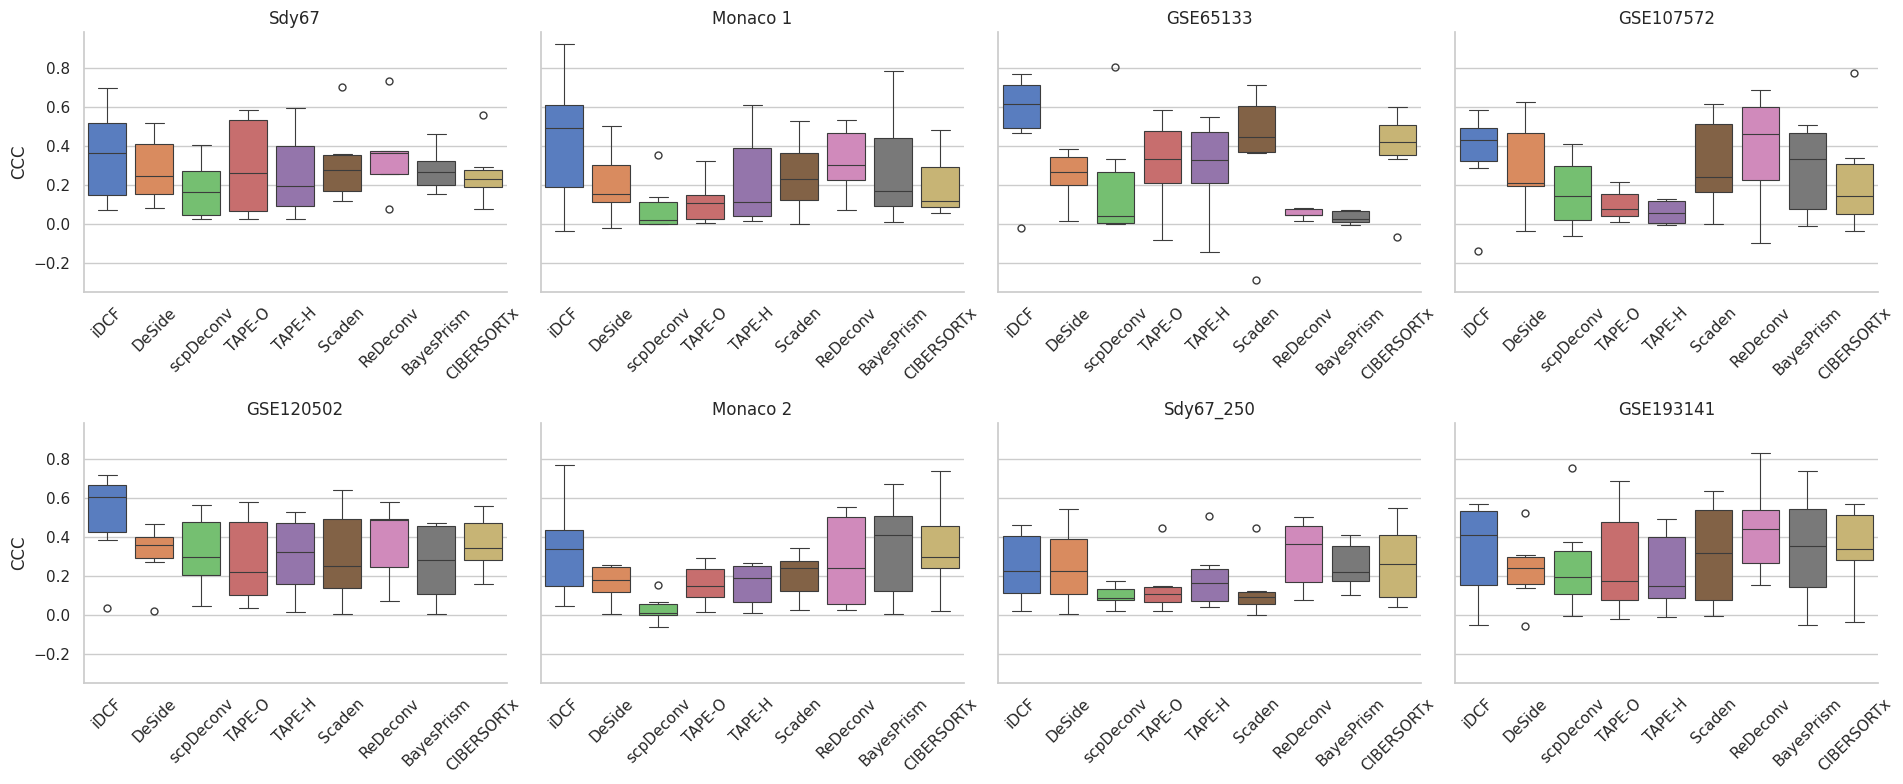

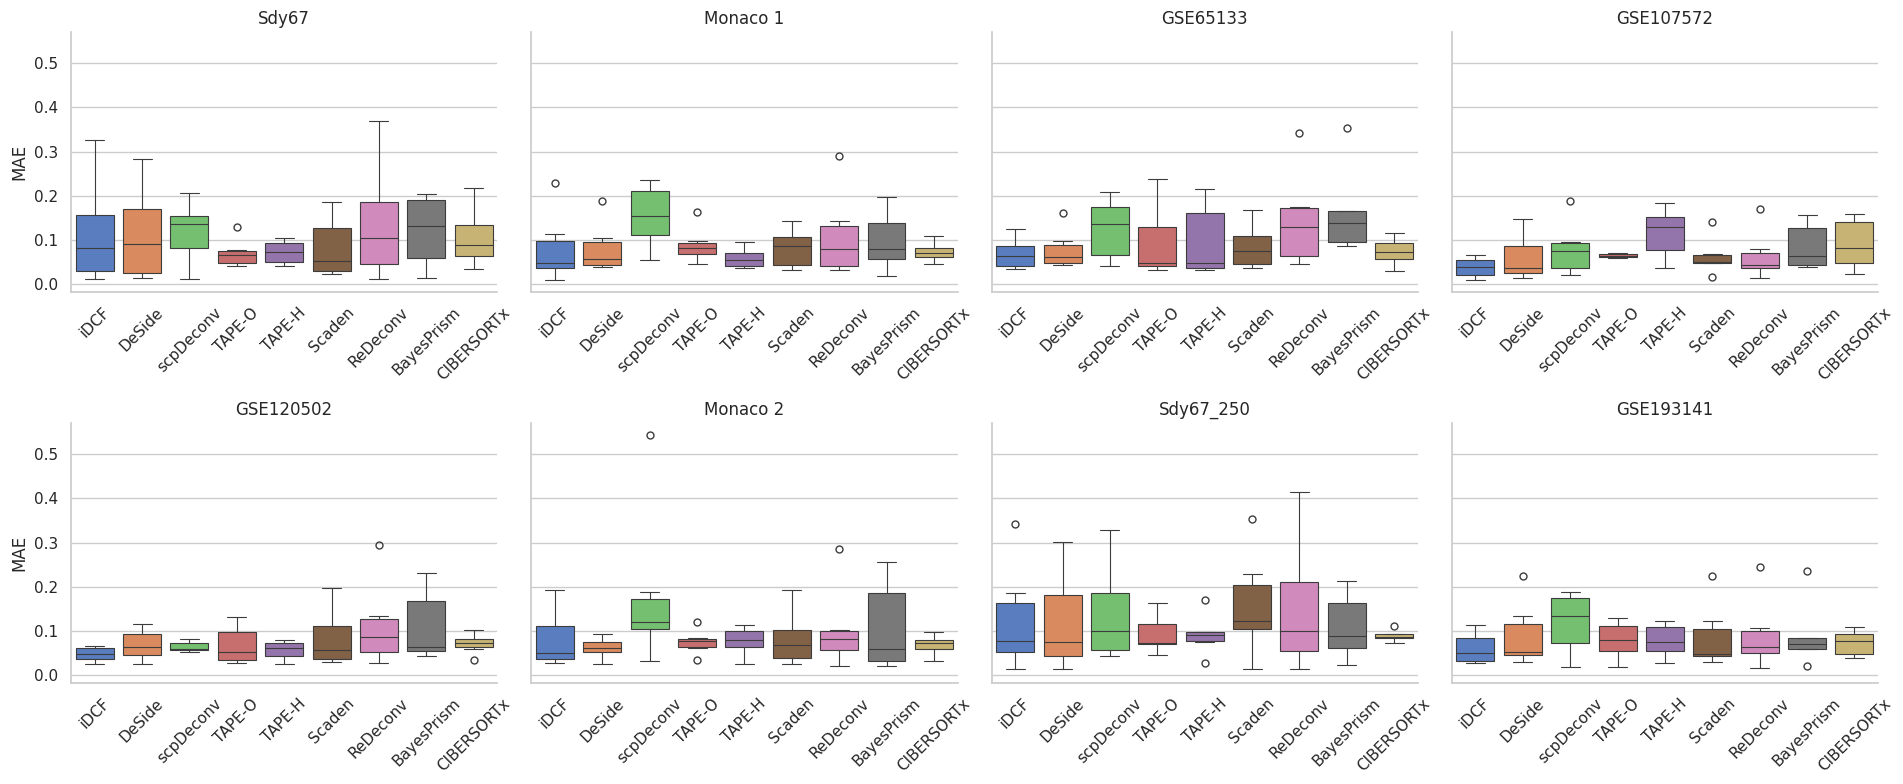

In [16]:
plot_boxplot(celltype_results, order, '../results/plot/celltype_boxplot')

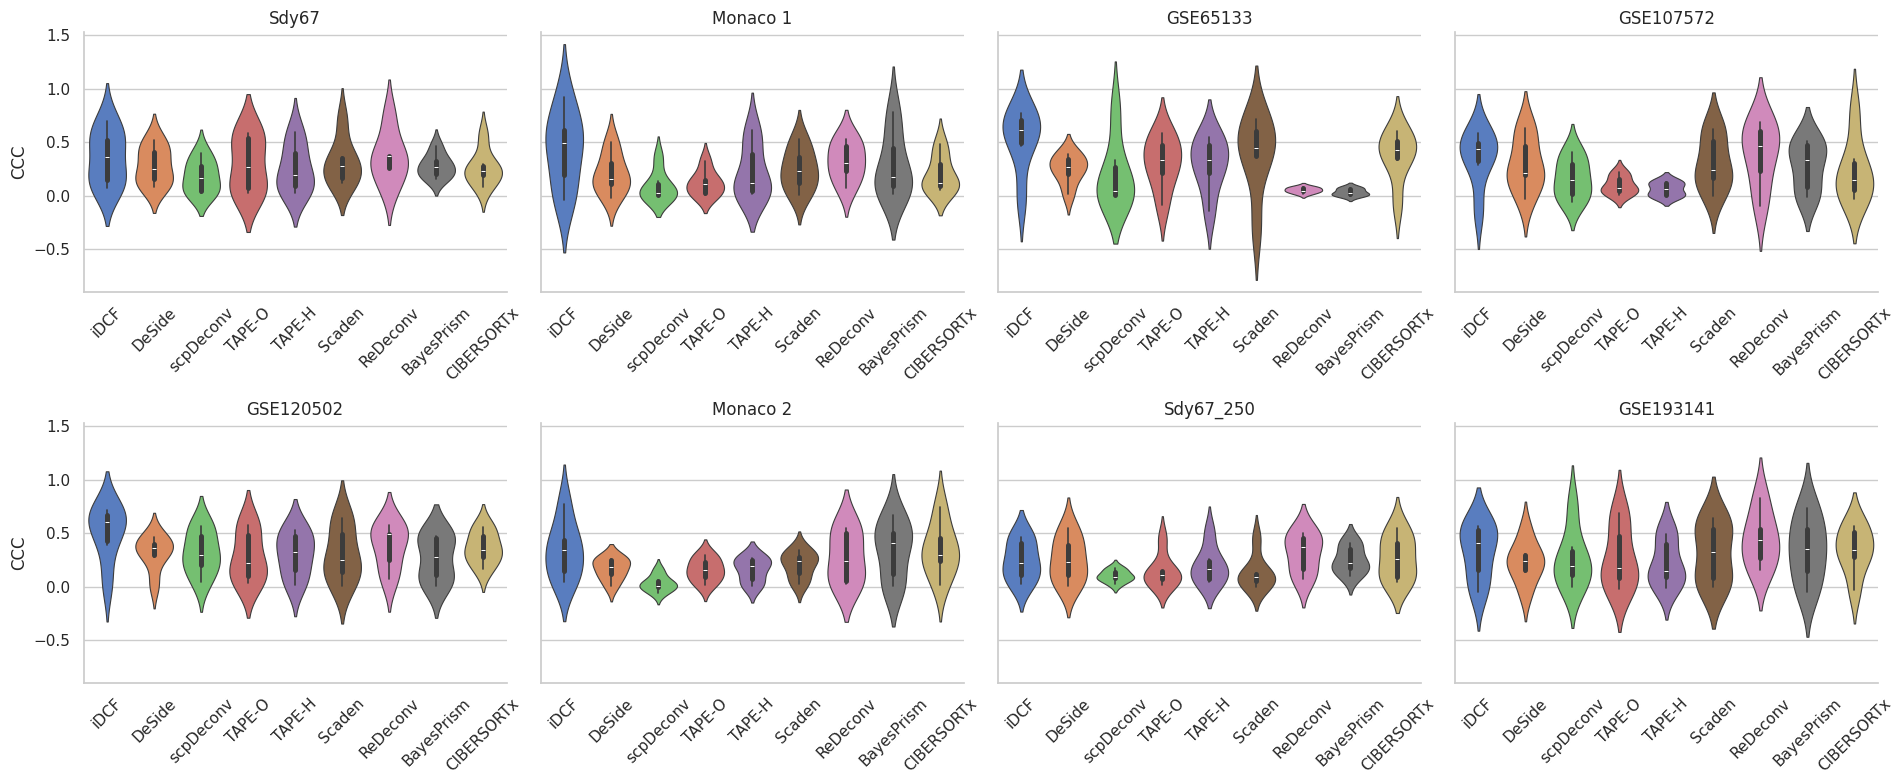

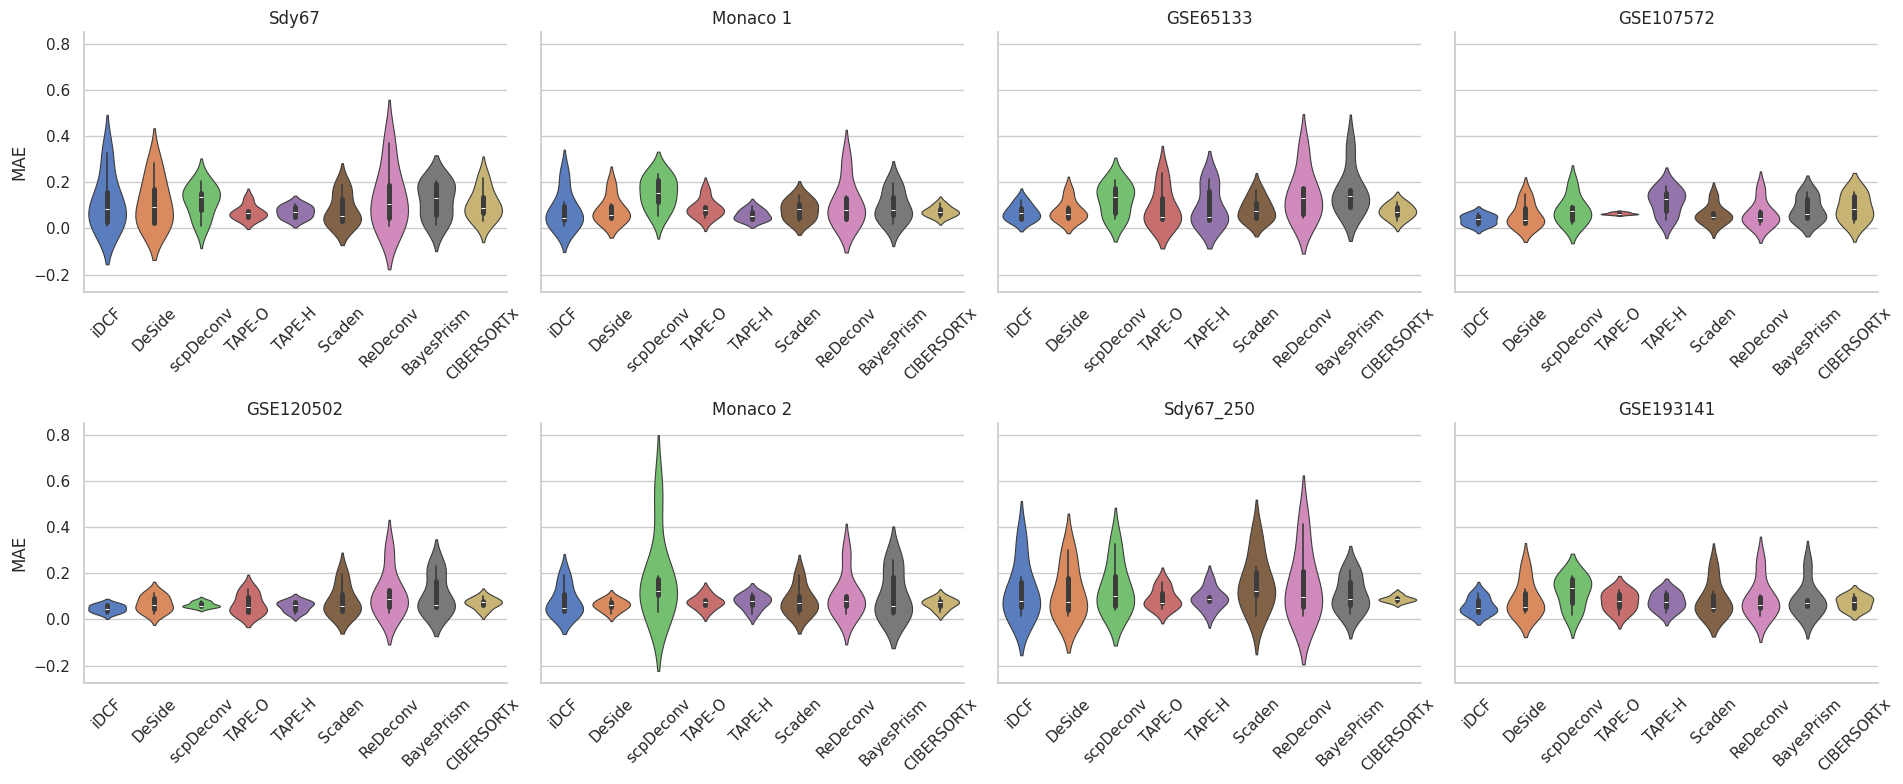

In [17]:
plot_violin(celltype_results, order, filename='../results/plot/celltype_violin')

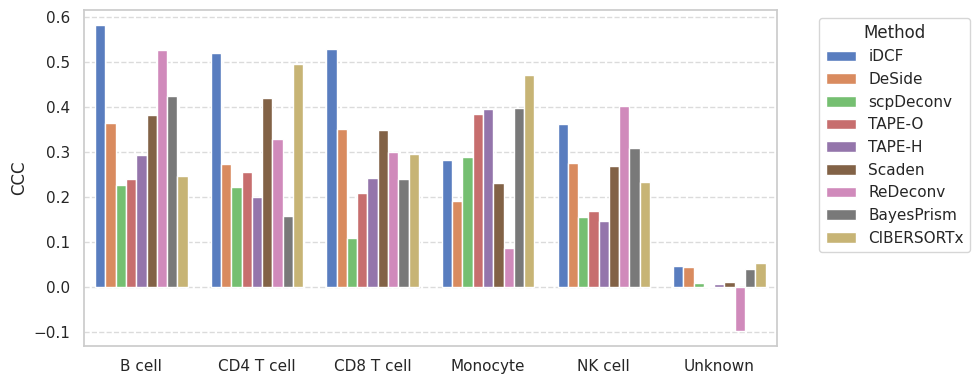

In [18]:
plot_ccc_comparison(celltype_results[celltype_results['Dataset'] != 'Brain_human'], metric='CCC', filename='../results/plot/celltype')

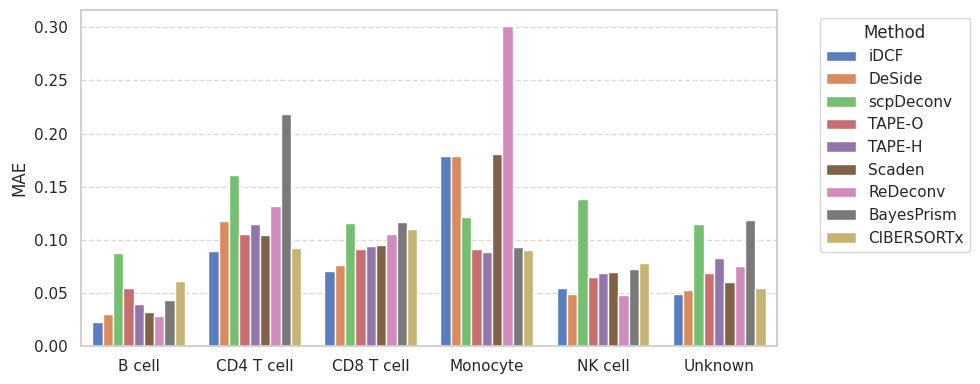

In [19]:
plot_ccc_comparison(celltype_results[celltype_results['Dataset'] != 'Brain_human'], metric='MAE', filename='../results/plot/celltype')

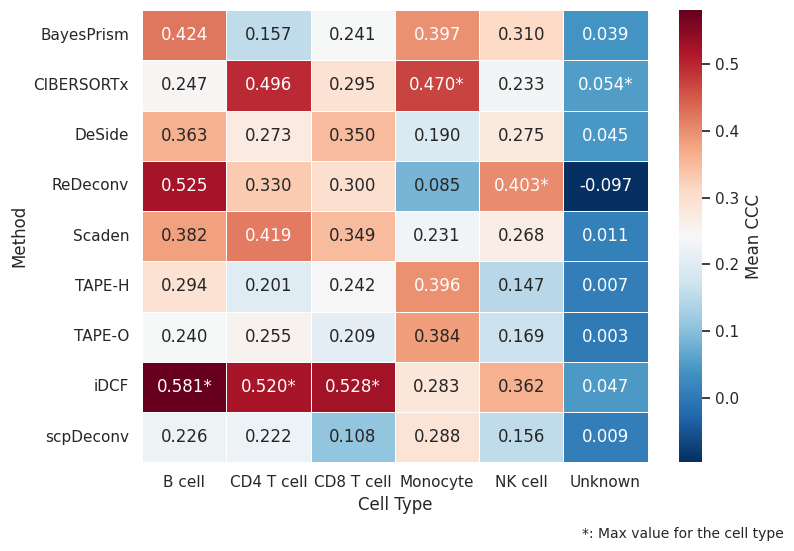

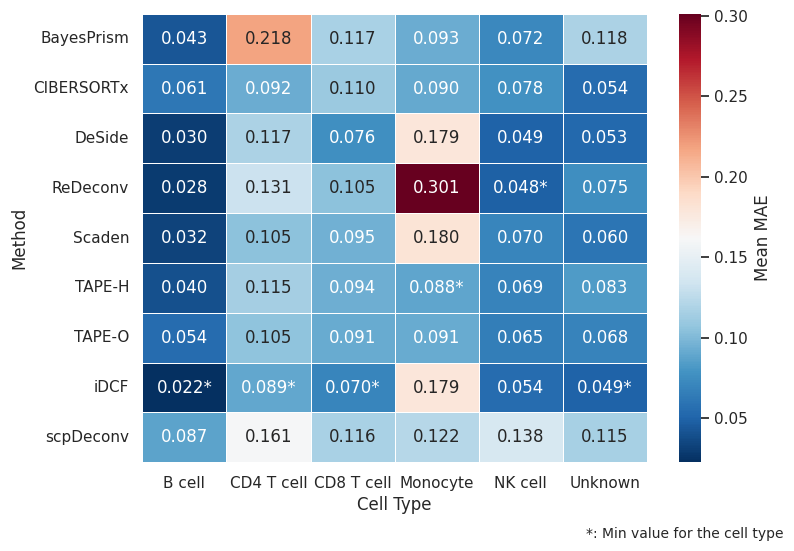

In [20]:
plot_performance_heatmap(celltype_results[celltype_results['Dataset'] != 'Brain_human'], metric='CCC', filename='../results/plot/celltype_comparison')
plot_performance_heatmap(celltype_results[celltype_results['Dataset'] != 'Brain_human'], metric='MAE', filename='../results/plot/celltype_comparison')

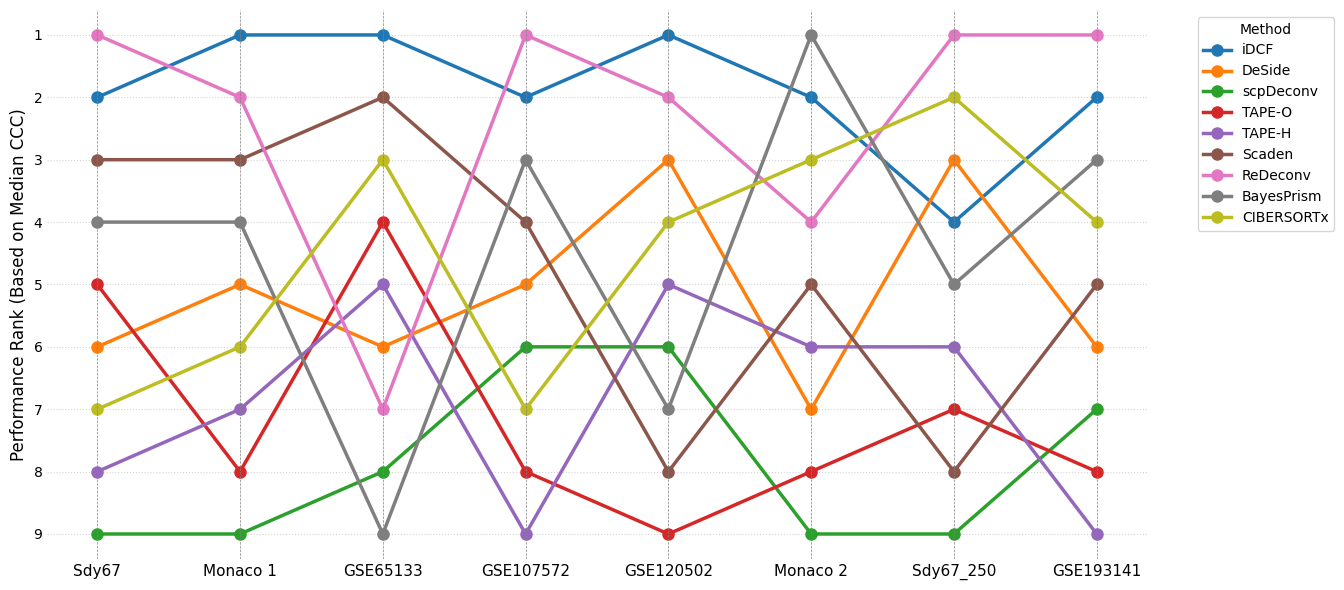

In [21]:
method_order_list = ['iDCF', 'DeSide', 'scpDeconv', 'TAPE-O', 'TAPE-H', 'Scaden', 'ReDeconv', 'BayesPrism', 'CIBERSORTx']
dataset_order_list = ['Sdy67','Monaco 1','GSE65133', 'GSE107572', 'GSE120502', 'Monaco 2', 'Sdy67_250', 'GSE193141']

# 使用新函数和您指定的顺序列表来调用
plot_ranking_slope_chart(
    celltype_results,
    dataset_order=dataset_order_list,
    method_order=method_order_list,
    filename='../results/plot/method_performance'
)


In [11]:
dataset_list = ['simu_test_pbmc6k']
# dataset_list = ['simu_test_donorA']
method_list = ['iDCF', 'DeSide', 'scpDeconv', 'TAPE-O', 'TAPE-H', 'Scaden', 'ReDeconv', 'BayesPrism', 'CIBERSORTx']

dataset_dict = {'simu_test_pbmc6k':'simu_test'}
# dataset_dict = {'simu_test_donorA':'simu_test'}

pred_label_results = []

for method in method_list:
    for dataset in dataset_list:
        print(f"############################## {method}: {dataset} ##############################")
        pred = pd.read_csv(f'../results/predicted/{method}/{dataset}.txt', sep='\t', index_col=0, header=0)
        label = pd.read_csv('../data/Real bulk/truth/'+dataset+'_truth.csv', index_col=0, header=0)

        pred.sort_index(axis=1, inplace=True)
        label.sort_index(axis=1, inplace=True)

        inter = pred.columns.intersection(label.columns)
        label = label[inter]
        pred = pred[inter]
        label = label / label.sum(axis=1).values.reshape(-1,1)
        pred = pred / pred.sum(axis=1).values.reshape(-1,1)

        for i in range(pred.shape[1]):
            celltype = pred.columns[i]
            pred_label_results.append({'pred':pred.iloc[:,i].values, 'label':label.iloc[:,i].values,
                                      'CellType':celltype, 'Dataset':dataset_dict[dataset], 'Method':method})

############################## iDCF: simu_test_pbmc6k ##############################
############################## DeSide: simu_test_pbmc6k ##############################
############################## scpDeconv: simu_test_pbmc6k ##############################
############################## TAPE-O: simu_test_pbmc6k ##############################
############################## TAPE-H: simu_test_pbmc6k ##############################
############################## Scaden: simu_test_pbmc6k ##############################
############################## ReDeconv: simu_test_pbmc6k ##############################
############################## BayesPrism: simu_test_pbmc6k ##############################
############################## CIBERSORTx: simu_test_pbmc6k ##############################


In [12]:
df = pd.DataFrame(pred_label_results)
df_expanded = df.explode(['pred', 'label']).reset_index(drop=True)
celltype_map = {'Bcells': 'B cell', 'CD4Tcells': 'CD4 T cell', 'CD8Tcells': 'CD8 T cell', 'Monocytes': 'Monocyte', 'NK': 'NK cell'}
df_expanded['CellType'] = df_expanded['CellType'].map(celltype_map)

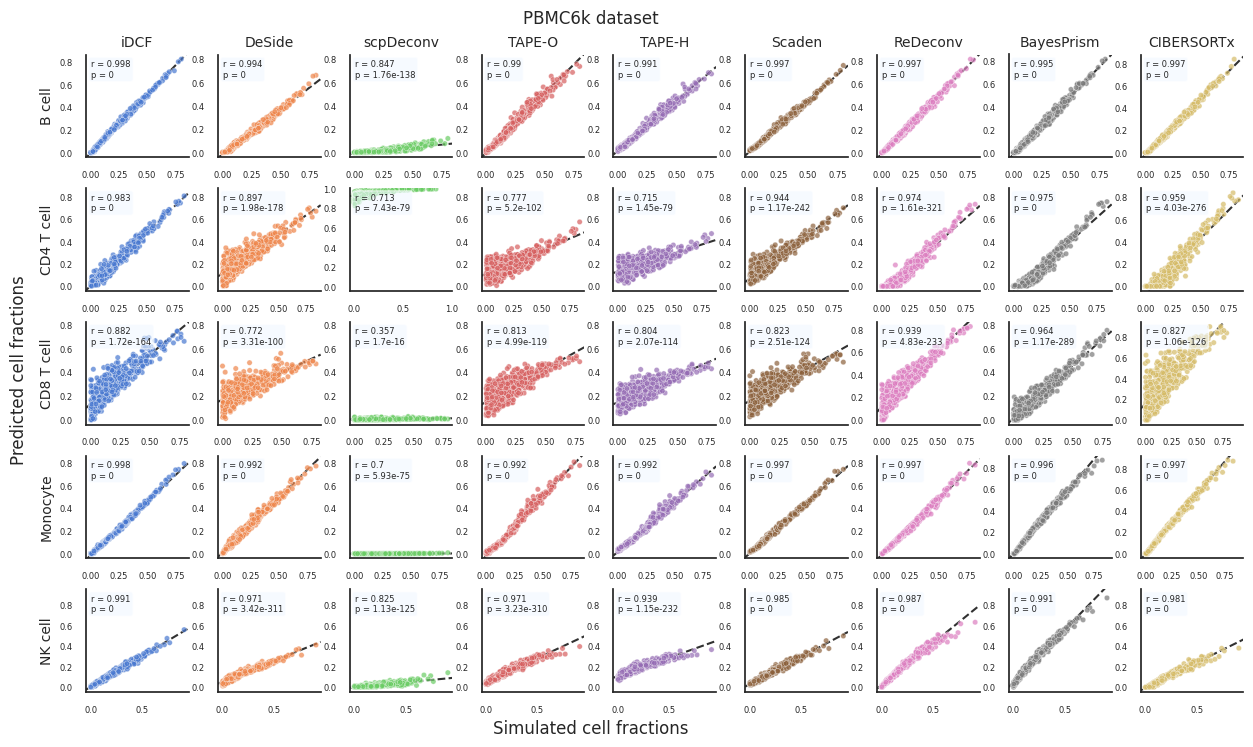

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# --- 2. 绘图 ---
sns.set_theme(style="white")

plot_regression_line = True

# ######################################################################
#  修改点 1: 添加您指定的调色板
# ######################################################################
colors4 = sns.color_palette("muted", 10)
colors = colors4

# ######################################################################
#  修改点 2: 在 relplot 中添加 hue, palette, 和 legend 参数
# ######################################################################
g = sns.relplot(
    data=df_expanded,
    x="label",
    y="pred",
    row="CellType",
    col="Method",
    kind="scatter",
    hue="Method",    # <--- 新增：按方法分配颜色
    palette=colors,  # <--- 新增：使用您指定的调色板
    legend=False,    # <--- 新增：移除图例（因为列标题已有说明）
    s=15,
    alpha=0.7,
    height=1.5,
    aspect=1,
    facet_kws={'sharex': False, 'sharey': False}
)

# --- 3. 添加注释和线条 ---
for i, row_name in enumerate(g.row_names):
    for j, col_name in enumerate(g.col_names):
        ax = g.axes[i, j]
        ax.tick_params(axis='both', labelsize=6)
        subset = df_expanded[(df_expanded['CellType'] == row_name) & (df_expanded['Method'] == col_name)]

        if len(subset) > 1:
            x_vals = subset['label'].astype(float)
            y_vals = subset['pred'].astype(float)

            r, p_value = pearsonr(x_vals, y_vals)
            annotation_text = f"r = {r:.3g}\np = {p_value:.3g}"
            ax.text(0.05, 0.95, annotation_text,
                    transform=ax.transAxes, fontsize=6,
                    horizontalalignment='left',
                    verticalalignment='top',
                    bbox=dict(boxstyle='round,pad=0.3', fc='aliceblue', alpha=0.6))

            lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]),
                    max(ax.get_xlim()[1], ax.get_ylim()[1])]
            ax.set_xlim(lims)
            ax.set_ylim(lims)

            if plot_regression_line:
                # ######################################################################
                #  修改点 3: (推荐) 将回归线改为黑色 'k--'，避免颜色冲突
                # ######################################################################
                m, b = np.polyfit(x_vals, y_vals, 1)
                ax.plot(lims, [m*lims[0]+b, m*lims[1]+b], 'k--', alpha=0.9, zorder=0, linewidth=1.5) # 'g--' 改为 'k--'
            else:
                ax.plot(lims, lims, 'r--', alpha=0.75, zorder=0, linewidth=1)

        ax.set_aspect('equal', adjustable='box')


# --- 4. 优化和自定义图像布局 ---
# g.fig.suptitle('DonorA dataset', fontsize=12)
g.fig.suptitle('PBMC6k dataset', fontsize=12)
g.set_titles('')
g.set_axis_labels('', '')

for j, col_name in enumerate(g.col_names):
    g.axes[0, j].set_title(col_name, fontsize=10)

for i, row_name in enumerate(g.row_names):
    g.axes[i, 0].set_ylabel(row_name, fontsize=10)

g.fig.text(0.5, 0.01, 'Simulated cell fractions', ha='center', va='bottom', fontsize=12)
g.fig.text(0.07, 0.5, 'Predicted cell fractions', ha='left', va='center', rotation=90, fontsize=12)

g.fig.subplots_adjust(left=0.12, bottom=0.07, top=0.92, right=0.99, hspace=0.3, wspace=0.1)


# --- 5. 保存和显示图像 ---
plt.savefig('../results/plot/simu_test_scatter_pbmc6k_heng.png', dpi=300)
# plt.savefig('../results/plot/simu_test_scatter_donorA_heng.png', dpi=300)
plt.show()